In [1]:
from importlib.metadata import version
import urllib.request
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
import summa
from summa.summarizer import summarize
import pandas as pd
from bs4 import BeautifulSoup
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 데이터 수집하기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv')
data_copy = data.copy()

In [3]:
data.sample(10)

,headlines,text
77152,Flight passenger spots man texting about sex a...,An airline passenger spotted another flyer tex...
69305,20 students in K'taka found with Blue Whale cu...,As many as 20 students at Kendriya Vidyalaya N...
13862,"Director said 'Petticoat uthao, ragdo aapne aa...","Amid the '#MeToo movement' in India, Chitrangd..."
75038,Philippine police kill 32 in deadliest night o...,Philippine police killed 32 people in a series...
38037,Uber driver arrested for sending obscene messa...,An Uber cab driver has been arrested in Chandi...
930,Airport privatisation proposal draws over 20 s...,The pre-bid conference of the government's air...
10831,Microsoft's Cortana chief Javier Soltero to qu...,Microsoft's digital assistant Cortana division...
80229,SRCC student slaps professor after scoring low...,A student from Delhi University's SRCC has sla...
41101,To support her is everything: Karthik to wife ...,Wishing luck to his wife and squash player Dip...
15673,Robert Vadra acting as de facto Congress presi...,BJP spokesperson Sambit Patra on Thursday clai...


# 데이터 전처리하기 (추상적 요약)

In [4]:
# 중복과 NULL값이 존재하는 데이터 제거
print('text 열에서 중복을 배제한 유일한 샘플 수:', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수:', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플 수: 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수: 98280


In [5]:
# 중복샘플 제거
data.drop_duplicates(subset=['text'], inplace=True)

In [6]:
# NULL값 2차 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
# 정규화 사전 생성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
# NLTK에서 제공하는 불용어 리스트
print('불용어 개수:', len(stopwords.words('english')))
print(stopwords.words('english'))

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, 'lxml').text  # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호로 닫힌 문자열 (...) 제거, 예) my husband (and myself!) for => my husband for
    sentence = re.sub('"', '', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거. 예) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 치환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. 예) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text만)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

불용어 개수: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [9]:
# 전처리 전후 비교 테스트
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [10]:
# data에 전처리 적용
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print('Text 전처리 후 결과: ', clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
# headlines는 불용어 제거를 수행하지 않게 설정
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print('headlines 전처리 후 결과: ', clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
# 비어있는 샘플들이 생겼을 수 있고, 해당 샘플들을 NULL 샘플로 대체
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

In [13]:
# NULL로 바꾼 비어있던 샘플 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

text 최소 길이 : 1
text 최대 길이 : 60
text 평균 길이 : 35.09968483123221
headlines 최소 길이 : 1
headlines 최대 길이 : 16
headlines 평균 길이 : 9.299532330215534


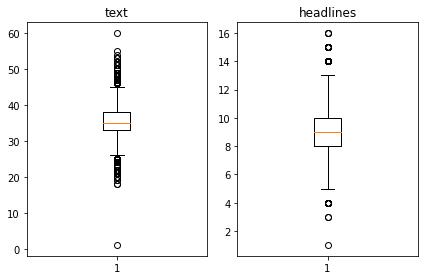

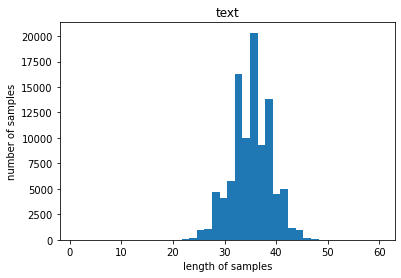

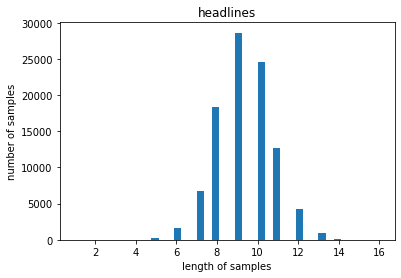

In [14]:
# 훈련에 사용할 샘플의 최대 길이를 지정.
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text 최소 길이 : {}'.format(np.min(text_len)))
print('text 최대 길이 : {}'.format(np.max(text_len)))
print('text 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
# 최대길이 설정
text_max_len = 50
headlines_max_len = 12

In [16]:
# 설정한 최대길이의 적합성
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


In [18]:
# 설정한 길이보다 길면 제외.
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97169


In [19]:
# headlines에 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [20]:
# decoder input 과 target을 Numpy 타입으로 저장.
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [21]:
# 훈련 데이터와 테스트 데이터로 분리.
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 섞은 데이터를 훈련데이터: 테스트데이터 8:2 로 분리
n_of_val = int(len(encoder_input) * 0.2)
print('테스트 데이터의 수:', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 수 :', len(encoder_input_train))
print('훈련 레이블의 수 :', len(decoder_input_train))
print('테스트 데이터의 수 :', len(encoder_input_test))
print('테스트 레이블의 수 :', len(decoder_input_test))

[ 5718 34155  6537 ... 22398 25451  7077]
테스트 데이터의 수: 19433
훈련 데이터의 수 : 77736
훈련 레이블의 수 : 77736
테스트 데이터의 수 : 19433
테스트 레이블의 수 : 19433


In [22]:
# vacabulary 만들기
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)  # 입력된 데이터로부터 단어 집합 생성, word_index에 저장됨

# 단어 집합에 등장 빈도수가 적은 훈련 데이터 제거
threshold = 7
total_cnt = len(src_tokenizer.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold 보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면 
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
    
print('단어 집합의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq) * 100)


단어 집합의 크기 : 69388
등장 빈도가 6번 이하인 희귀 단어의 수: 47351
단어 집합에서 희귀 단어를 제외시킬 경우 단어 집합의 크기 22037
단어 집합에서 희귀 단어의 비율: 68.24090620856632
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.510201030491512


In [23]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab)  # 단어 집합의 크기를 22000로 제한
src_tokenizer.fit_on_texts(encoder_input_train)  # 단어 집합 재생성

In [24]:
# 텍스트 데이터인 단어들을 정수 인코딩
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 결과 샘플 확인
print(encoder_input_train[:3])

[[458, 50, 2740, 2332, 7, 165, 2332, 300, 859, 2332, 170, 2332, 423, 221, 453, 84, 1963, 6305, 999, 179, 655, 343, 22, 673, 1388, 976, 7435, 3654, 77, 242, 33, 312], [5279, 7, 1216, 245, 3630, 322, 3, 343, 12, 6844, 17, 5279, 438, 31, 4926, 5151, 1974, 7849, 812, 7238, 3343, 356, 128, 4965], [83, 133, 13, 159, 252, 54, 3518, 2162, 3272, 161, 62, 6157, 88, 143, 22, 1061, 4726, 300, 203, 2544, 3272, 96, 2162, 409, 2493, 4726, 961, 4726, 196, 2024, 188, 607, 950, 466]]


In [25]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [26]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq) * 100)

단어 집합 크기 : 29997
등장 빈도가 5번 이하인 희귀 단어의 수: 19636
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10361
단어 집합에서 희귀 단어의 비율: 65.45987932126546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.7224787680446525


In [27]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 변환 체크
print('input ', decoder_input_train[:5])
print('target ', decoder_target_train[:])

input  [[1, 638, 193, 2620, 2836, 37, 125, 406, 274], [1, 3758, 8763, 8, 282, 4805, 3149, 3, 172, 4, 1992], [1, 410, 26, 132, 185, 10, 112, 1993, 17, 795, 3877, 4, 25], [1, 25, 9533, 497, 1932, 3, 40, 454, 2837, 304], [1, 292, 2673, 3, 224, 7610, 15, 2025, 9534]]
target  [[638, 193, 2620, 2836, 37, 125, 406, 274, 2], [3758, 8763, 8, 282, 4805, 3149, 3, 172, 4, 1992, 2], [410, 26, 132, 185, 10, 112, 1993, 17, 795, 3877, 4, 25, 2], [25, 9533, 497, 1932, 3, 40, 454, 2837, 304, 2], [292, 2673, 3, 224, 7610, 15, 2025, 9534, 2], [313, 1228, 660, 3, 2051, 2466, 214, 1245, 2], [9, 6796, 440, 281, 37, 4, 44, 1138, 28, 2], [9535, 656, 7, 4362, 177, 416, 160, 131, 906, 36, 2], [1779, 70, 720, 5, 1217, 1721, 8, 146, 783, 2], [519, 1263, 976, 230, 2291, 4129, 3, 1056, 647, 625, 1449, 2], [234, 1498, 7, 196, 1001, 796, 195, 8, 93, 122, 2], [208, 78, 1218, 15, 178, 314, 48, 31, 5168, 4, 2], [1083, 220, 114, 76, 218, 4, 149, 2], [22, 40, 449, 305, 68, 52, 6, 130, 3, 487, 242, 2], [67, 626, 872, 39, 3,

In [28]:
# 길이가 1인 headlines 삭제
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 데이터 수 :', len(drop_train), len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터, 레이블 개수 :', len(encoder_input_train), len(decoder_input_train))
print('테스트 데이터, 레이블 개수 :', len(encoder_input_test), len(decoder_input_test))

삭제할 데이터 수 : 0 0
훈련 데이터, 레이블 개수 : 77736 77736
테스트 데이터, 레이블 개수 : 19433 19433


In [29]:
# padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 어텐션 메커니즘 사용하기 (추상적 요약)

In [30]:
# 인코더
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [31]:
# 디코더
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [32]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [33]:
# 어텐션
attn_layer = AdditiveAttention(name='attention_layer')

attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
304/304 [==============================] - 38s 101ms/step - loss: 5.6100 - val_loss: 5.1854
Epoch 2/50
304/304 [==============================] - 30s 100ms/step - loss: 5.0299 - val_loss: 4.7926
Epoch 3/50
304/304 [==============================] - 31s 102ms/step - loss: 4.6874 - val_loss: 4.5445
Epoch 4/50
304/304 [==============================] - 32s 105ms/step - loss: 4.4357 - val_loss: 4.3721
Epoch 5/50
304/304 [==============================] - 32s 105ms/step - loss: 4.2330 - val_loss: 4.2152
Epoch 6/50
304/304 [==============================] - 32s 104ms/step - loss: 4.0618 - val_loss: 4.1052
Epoch 7/50
304/304 [==============================] - 32s 105ms/step - loss: 3.9172 - val_loss: 4.0185
Epoch 8/50
304/304 [==============================] - 32s 104ms/step - loss: 3.7878 - val_loss: 3.9409
Epoch 9/50
304/304 [==============================] - 32s 104ms/step - loss: 3.6737 - val_loss: 3.8816
Epoch 10/50
304/304 [==============================] - 32s 104ms/step - l

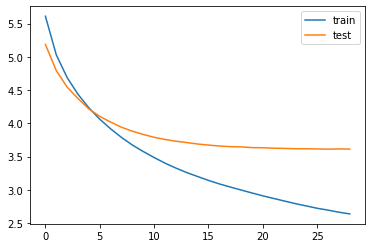

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [36]:
# 인퍼런스 모델
# 단어 사전
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 디코더
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [37]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token
            
        if(sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True
            
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        e_h, e_c = h, c
    
    return decoded_sentence

# 실제 결과와 요약문 비교하기 (추상적 요약)

In [38]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i] + ' '
    return temp

def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [39]:
for i in range(175, 200):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 headlines :", seq2headlines(decoder_input_test[i]))
    print("예측 headlines :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print('\n')

원문 : pune court granted day extension police file chargesheet case five activists arrested june alleged maoist links involvement bhima koregaon violence activists day judicial custody ends september citing arrest five activists week police requested extension 
실제 headlines : cops get day extension to file chargesheet on activists 
예측 headlines :  court orders bail to arrest in riots case


원문 : europe based researchers claimed fear snakes humans learn scientists found six month old babies got shown pictures instead fish size colour scientists fear humans million years 
실제 headlines : fear of spiders snakes deeply in humans study 
예측 headlines :  scientists study old humans to make humans


원문 : aerospace manufacturer spacex ceo elon musk said new nasa bill passed us president donald trump make difference existing projects mars related missions bill allows nasa continue working private sector provides added funding mars musk said notably elon musk member trump advisory council 
실제 headl

* 대부분의 문장이 완성적이지 않지만, 일부 예측 헤드라인을 제외하고는 기사내용이 핵심단어들이 출현하는 경향을 보이고 있습니다.

# Summa을 이용해서 추출적 요약해보기

In [40]:
import requests
from summa.summarizer import summarize

In [41]:
for i in range(175, 200):
    print("원문 :", data_copy.text[i])
    print("실제 headlines :", data_copy.headlines[i])
    print("예측 headlines :", summarize(data_copy.text[i], words=headlines_max_len))
    print('\n')

원문 : BJP leader Sitaram Adivasi, a first-time MLA from Vijaypur constituency in Madhya Pradesh, is being weighed against coins by his supporters to make a concrete house. "I will definitely pay back their affection with development of the area," Adiwasi said. As per his 2018 Assembly Elections affidavit, the 55-year-old owns a tractor on loan, a two-acre land, and â¹46,733.
실제 headlines : Supporters weigh BJPâMLA in coins, donate for his house in MP
예측 headlines : 


원문 : AAP MP Bhagwant Mann will again take charge as the chief of the party's Punjab unit on Wednesday. In March 2018, Mann had tendered his resignation after Kejriwal apologised to Shiromani Akali Dal (SAD) leader Bikram Singh Majithia over allegations of his involvement in drug trade. However, his resignation was rejected by Punjab AAP last week. 
실제 headlines : Bhagwant Mann to take over as Punjab chief of AAP again
예측 headlines : However, his resignation was rejected by Punjab AAP last week.


원문 : Flipkart CEO Kalya

* 기존의 내용에서 추출해서 그런지 문장의 완성도는 양호한데, 핵심단어들이 잘 있다고는 판단하기 어려운 상태고, 예측된 headline들이 대체로 문장의 시작부분이나 끝부분을 그대로 가져온 형태입니다.

|    |문법완성도|핵심단어|
|:---|:-----:|:-----:|
|Abstractive| ↓ | ↑ |
|Extractive| ↑ | ↓ |

# 회고

* Extractive 방식은 문장의 완성도는 좋지만, 문장의 첫 문장이나 마지막 문장을 그대로 가져와서 그런것 같고, 내용의 첫 문장이나 마지막 문장이 정해진 단어의 수 이하면 추출을 해오지만, 그렇지 않은 경우 아예 문장생성이 안되는 문제가 있는것 같습니다.
* Abstractive 방식은 문장완성도가 떨어지지만 Attention 방식을 사용해서 그런지 핵심단어가 일부 포함되어있는 것을 보아 데이터량을 늘리거나, 파라미터에 변화를 주는 등 좀 더 개선하면 완성도있는 문장들을 생성해 낼 수 있을 것 같습니다.
